In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random

import os
import PIL
import pathlib


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [4]:
!pip install split-folders

In [5]:
import splitfolders

In [7]:
base_ds = 'data/Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [7]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

In [9]:
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

Dataset Exploration
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


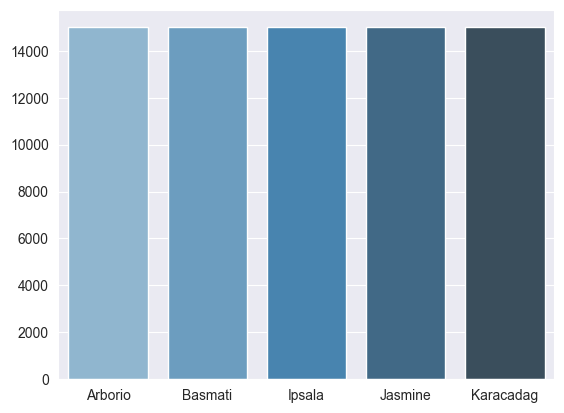

In [10]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.show()

In [13]:
pip install opencv-python

     ---------------------------------------- 35.6/35.6 MB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
import cv2

Image dimensions: (250, 250, 3)


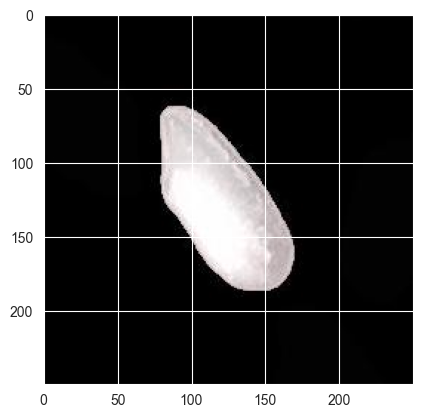

In [13]:
sample_img = cv2.imread('imgs/test/Arborio/Arborio (10).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [14]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

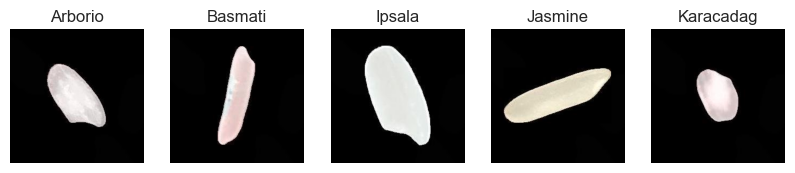

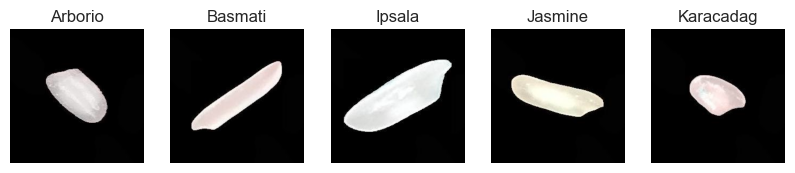

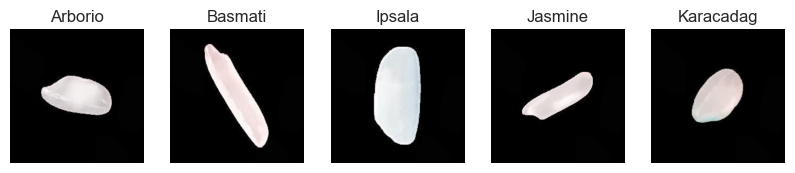

In [15]:
for i in range(3):
  load_random_img(base_ds, rice_classes)

In [16]:
batch_size = 128
img_height, img_width = 175, 175
input_shape = (img_height, img_width, 3)

In [17]:
datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [19]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Vanilla CNN Model

In [20]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [21]:
model_vanilla.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vanilla.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 173, 173, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 173, 173, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 173, 173, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 173, 173, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 87, 32)       0         
 )                                                               
                                                        

# Callbacks

In [22]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [24]:
history1 = model_vanilla.fit(train_ds, epochs = 8, validation_data = val_ds, callbacks=callbacks)

Epoch 1/8
411/411 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9644 
Epoch 1: val_accuracy improved from -inf to 0.20009, saving model to saved_models\model_vanilla.hdf5
411/411 [==============================] - 6758s 16s/step - loss: 0.1058 - accuracy: 0.9644 - val_loss: 6.8198 - val_accuracy: 0.2001 - lr: 0.0010
Epoch 2/8
411/411 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9889 
Epoch 2: val_accuracy improved from 0.20009 to 0.98018, saving model to saved_models\model_vanilla.hdf5
411/411 [==============================] - 6708s 16s/step - loss: 0.0342 - accuracy: 0.9889 - val_loss: 0.0559 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 3/8
411/411 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9895 
Epoch 3: val_accuracy did not improve from 0.98018
411/411 [==============================] - 6766s 16s/step - loss: 0.0338 - accuracy: 0.9895 - val_loss: 0.3483 - val_accuracy: 0.8987 - lr: 0.0010
Epoch 4/8
411/4

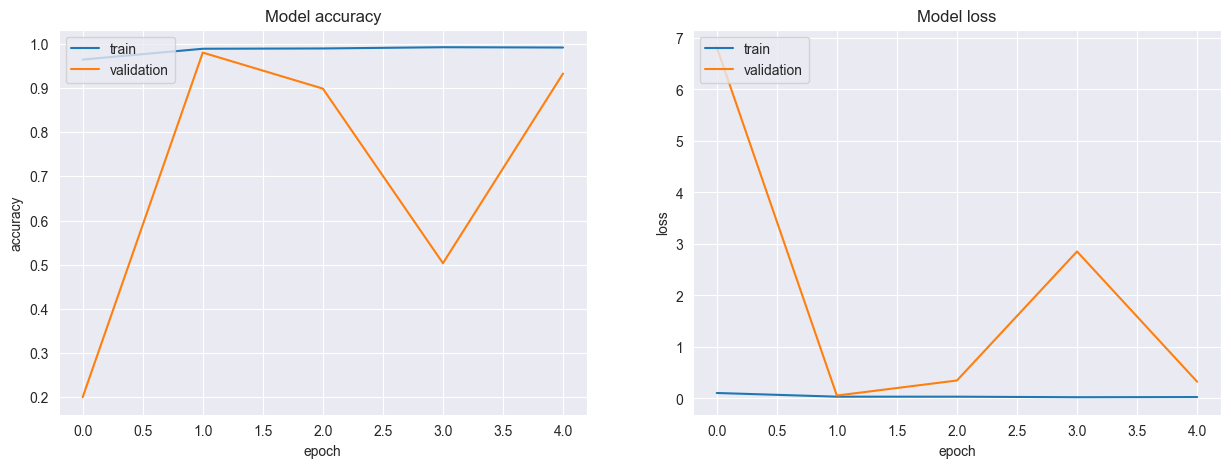

In [25]:
model_vanilla.load_weights('saved_models/model_vanilla.hdf5')
plot_train_history(history1)

# Model Evaluation of Vanilla CNN

In [26]:
score1 = model_vanilla.evaluate(test_ds, verbose=1)

88/88 [==============================] - 290s 3s/step - loss: 0.0564 - accuracy: 0.9803


In [27]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_vanilla.predict(test_ds)

88/88 [==============================] - 280s 3s/step


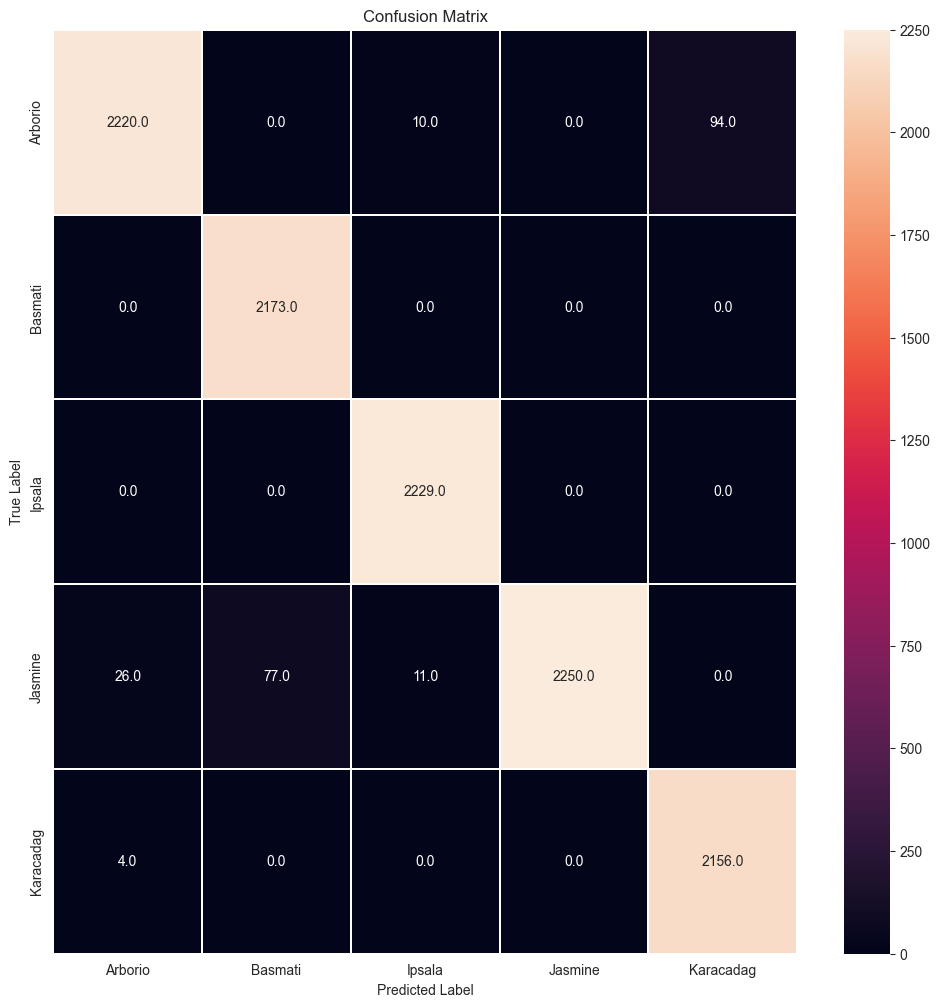

In [28]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [29]:
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Arborio,0.955250,0.986667,0.970704,2250.000000
Basmati,1.000000,0.965778,0.982591,2250.000000
Ipsala,1.000000,0.990667,0.995311,2250.000000
Jasmine,0.951777,1.000000,0.975293,2250.000000
Karacadag,0.998148,0.958222,0.977778,2250.000000
accuracy,0.980267,0.980267,0.980267,0.980267
macro avg,0.981035,0.980267,0.980335,11250.000000
weighted avg,0.981035,0.980267,0.980335,11250.000000


# Transfer Learning

In [30]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

58889256/58889256 [==============================] - 18s 0us/step


In [31]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 175, 175, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dense_4 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
___________________________________________

In [33]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [34]:
history2 = model_vgg16.fit(train_ds, epochs = 5, validation_data = val_ds, callbacks=callbacks)

Epoch 1/5
411/411 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9583 
Epoch 1: val_accuracy improved from -inf to 0.98649, saving model to saved_models\model_vgg16.hdf5
411/411 [==============================] - 7081s 17s/step - loss: 0.1646 - accuracy: 0.9583 - val_loss: 0.0493 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 2/5
411/411 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9869 
Epoch 2: val_accuracy improved from 0.98649 to 0.99138, saving model to saved_models\model_vgg16.hdf5
411/411 [==============================] - 7103s 17s/step - loss: 0.0448 - accuracy: 0.9869 - val_loss: 0.0316 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 3/5
411/411 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9881 
Epoch 3: val_accuracy did not improve from 0.99138
411/411 [==============================] - 7104s 17s/step - loss: 0.0356 - accuracy: 0.9881 - val_loss: 0.0309 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 4/5
411/411 [

In [35]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

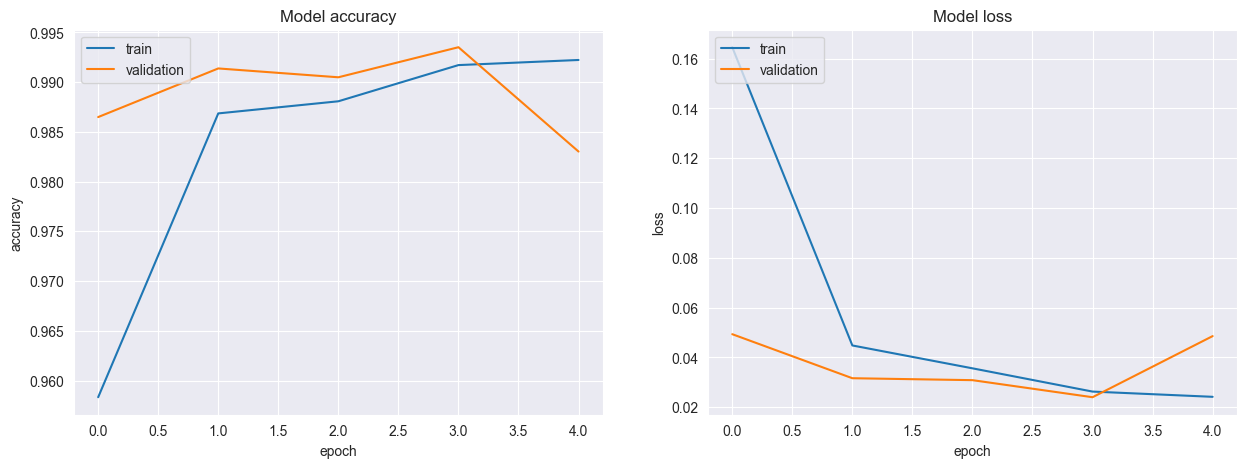

In [36]:
plot_train_history(history2)

In [40]:
Y_pred = model_vgg16.predict(test_ds)

88/88 [==============================] - 1262s 14s/step


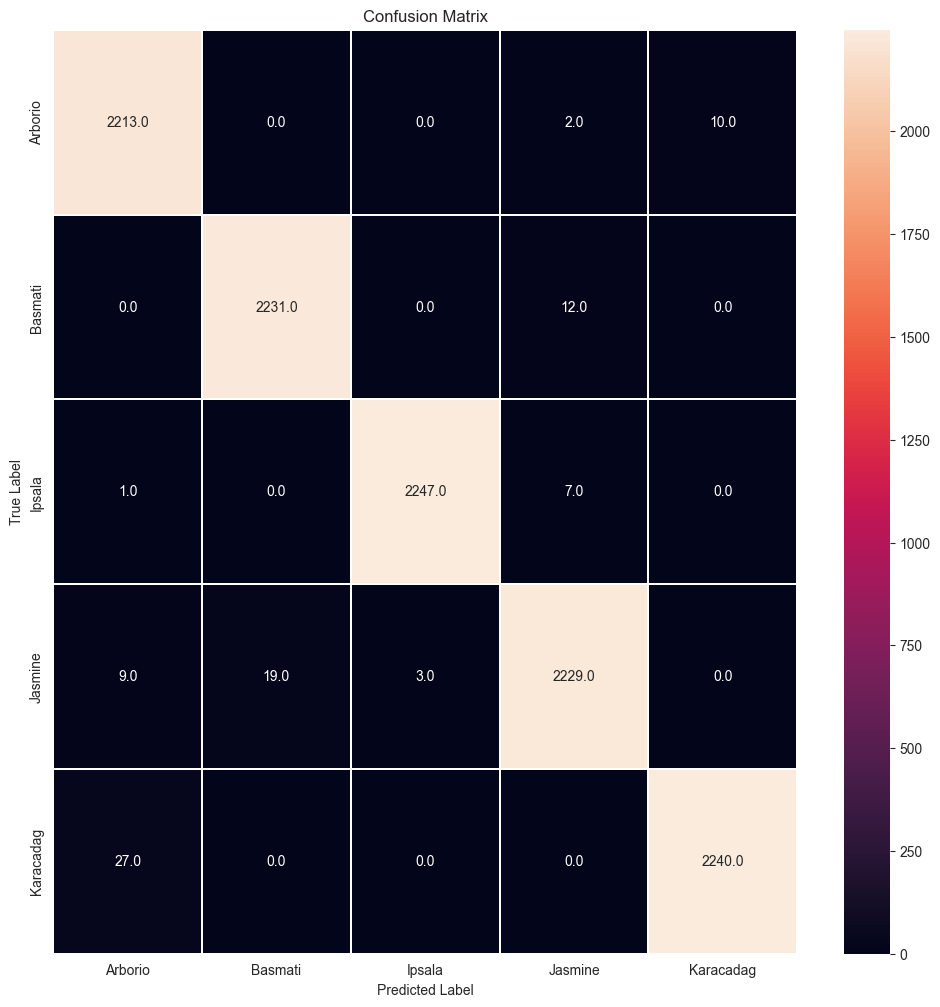

In [41]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [42]:
report2 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df2 = pd.DataFrame(report1).transpose()
df2

,precision,recall,f1-score,support
Arborio,0.955250,0.986667,0.970704,2250.000000
Basmati,1.000000,0.965778,0.982591,2250.000000
Ipsala,1.000000,0.990667,0.995311,2250.000000
Jasmine,0.951777,1.000000,0.975293,2250.000000
Karacadag,0.998148,0.958222,0.977778,2250.000000
accuracy,0.980267,0.980267,0.980267,0.980267
macro avg,0.981035,0.980267,0.980335,11250.000000
weighted avg,0.981035,0.980267,0.980335,11250.000000


In [37]:
score2 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

88/88 [==============================] - 1235s 14s/step - loss: 0.0227 - accuracy: 0.9920
Model 1 Vanilla Loss: 0.05636372044682503, Accuracy: 98.02666902542114
Model 2 VGG16 Loss: 0.022706663236021996, Accuracy: 99.19999837875366


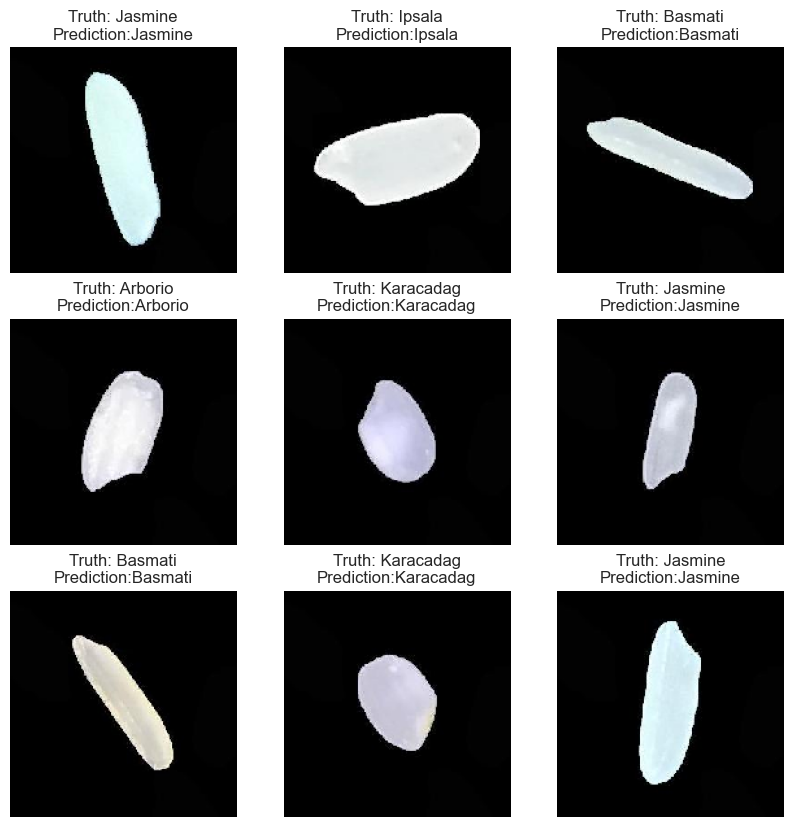

In [39]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = rice_classes[np.argmax(score)]
    plt.title(f'Truth: {rice_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)